In [156]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt


# Load X_test from CSV
X_test_df = pd.read_csv('X_test.csv')

# Set the date column as the index
X_test_df.set_index('date', inplace=True)

# Ensure the date column is in datetime format
X_test_df.index = pd.to_datetime(X_test_df.index)

"""
# Number of rows to remove from the top and bottom
rows_to_remove_top = 0
rows_to_remove_bottom = 0

# Slice the DataFrame to remove the rows
X_test_df = X_test_df.iloc[rows_to_remove_top: -rows_to_remove_bottom]

# Optionally, save the modified DataFrame to a new CSV file
X_test_df.to_csv('X_test_modified.csv')
"""

X_test_df['is_holiday'] = False

print(X_test_df.head())
print(X_test_df.tail())


                     term_date  is_holiday  day_of_week  month  day_of_year  \
date                                                                          
2023-02-05 03:00:00      False       False            6      2           36   
2023-02-05 04:00:00      False       False            6      2           36   
2023-02-05 05:00:00      False       False            6      2           36   
2023-02-05 06:00:00      False       False            6      2           36   
2023-02-05 07:00:00      False       False            6      2           36   

                     week_of_year  hour  weighted_day_of_year  year  \
date                                                                  
2023-02-05 03:00:00             5     3                  3600  2023   
2023-02-05 04:00:00             5     4                  3600  2023   
2023-02-05 05:00:00             5     5                  3600  2023   
2023-02-05 06:00:00             5     6                  3600  2023   
2023-02-05 07:00:00 

In [157]:
# -*- coding: utf-8 -*-
"""
Define holidays
"""

from pandas.tseries.holiday import (
    AbstractHolidayCalendar, DateOffset, EasterMonday, GoodFriday, Holiday, MO,
    next_monday, next_monday_or_tuesday
    )

class VancouverHolidayCalendar(AbstractHolidayCalendar):
    """
    Uses the pandas AbstractHolidayCalendar class to create a class for
    Vancouver holidays:
    Adjusts for observance date if set holidays fall on weekends
    New years - Jan 1
    Family Day - 3rd Monday in February
    Good Friday
    Easter Monday
    Victoria Day - Last Monday before May 25
    Canada Day - July 1
    Heritage Day - August 1
    Labour Day - September 1
    Thanksgiving - Second Monday in October
    Remembrance Day - November 11
    Christmas Day - December 25
    Boxing Day - December 26
    Additional holidays from December 25 to January 1
    See Pandas documentation for more information on holiday calendars
    http://pandas.pydata.org/pandas-docs/stable/timeseries.html#holidays-holiday-calendars
    Some sample code is here:
        http://mapleoin.github.io/perma/python-uk-business-days
        http://stackoverflow.com/documentation/pandas/7976/holiday-calendars#t=201703131711384942824
    """
    rules = [
        Holiday('New Years Day', month=1, day=1),
        Holiday('Family Day',
                month=2, day=1, offset=DateOffset(weekday=MO(3))),
        GoodFriday,
        EasterMonday,
        Holiday('Victoria Day',
                month=5, day=25, offset=DateOffset(weekday=MO(-1))),
        Holiday('Canada Day', month=7, day=1),
        Holiday('Labour Day',
                month=9, day=1, offset=DateOffset(weekday=MO(1))),
        Holiday('National Day for Truth and Reconciliation', month=9, day=30),
        Holiday('Thanksgiving',
                month=10, day=1, offset=DateOffset(weekday=MO(2))),
        Holiday('Remembrance Day',
                month=11, day=11),
        Holiday('Christmas Eve', month=12, day=24),
        Holiday('Christmas Day', month=12, day=25),
        Holiday('Boxing Day',
                month=12, day=26),
        Holiday('Additional Holiday 1', month=12, day=29),
        Holiday('Additional Holiday 2', month=12, day=28),
        Holiday('Additional Holiday 3', month=12, day=29),
        Holiday('Additional Holiday 4', month=12, day=30),
        Holiday('New Years Eve', month=12, day=31)
    ]


In [158]:
# Function to create features from the datetime index
def create_features(df, label=None):
            """
            Create time series features from the datetime index
            """
            df = df.copy()

            df['term_date'] = False
            #df['is_holiday'] = False

            df['date'] = df.index
            df['day_of_week'] = df['date'].dt.dayofweek
            df['month'] = df['date'].dt.month
            df['day_of_year'] = df['date'].dt.dayofyear
            df['week_of_year'] = df['date'].dt.isocalendar().week
            
            df['hour'] = df['date'].dt.hour  # Add hour feature

            # Apply weight to the day_of_year column
            weight = 100  # You can adjust this weight as needed
            df['weighted_day_of_year'] = df['day_of_year'] * weight
            
            df['year'] = df['date'].dt.year
            df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
            df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
            
            # Seasonality features
            df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
            df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
            df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
            df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
            df['sin_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
            df['cos_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
            df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
            df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

            # Seasonal indices (if applicable)
            # Autoregressive features (if applicable)
            # Time since last event (if applicable)
            # Day/night indicator
            df['is_day'] = np.where((df['hour'] >= 6) & (df['hour'] <= 18), 1, 0)
            
            # Day/night duration
            df['day_duration'] = np.where(df['is_day'] == 1, 12 - df['hour'], 0)
            df['night_duration'] = np.where(df['is_day'] == 0, df['hour'], 0)
            
            # Weather data (if available)
            # Special event indicators (if applicable)
            # Trend features (if applicable)

            
            
            return df

In [159]:
X_test_df

,term_date,is_holiday,day_of_week,month,day_of_year,week_of_year,hour,weighted_day_of_year,year,is_month_start,...,cos_hour,sin_day,cos_day,sin_week,cos_week,sin_month,cos_month,is_day,day_duration,night_duration
date,,,,,,,,,,,,,,,,,,,,,
2023-02-05 03:00:00,False,False,6,2,36,5,3,3600,2023,0,...,7.071068e-01,0.580455,0.814292,-0.781831,0.62349,0.866025,5.000000e-01,0,0,3
2023-02-05 04:00:00,False,False,6,2,36,5,4,3600,2023,0,...,5.000000e-01,0.580455,0.814292,-0.781831,0.62349,0.866025,5.000000e-01,0,0,4
2023-02-05 05:00:00,False,False,6,2,36,5,5,3600,2023,0,...,2.588190e-01,0.580455,0.814292,-0.781831,0.62349,0.866025,5.000000e-01,0,0,5
2023-02-05 06:00:00,False,False,6,2,36,5,6,3600,2023,0,...,6.123234e-17,0.580455,0.814292,-0.781831,0.62349,0.866025,5.000000e-01,1,6,0
2023-02-05 07:00:00,False,False,6,2,36,5,7,3600,2023,0,...,-2.588190e-01,0.580455,0.814292,-0.781831,0.62349,0.866025,5.000000e-01,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 19:00:00,False,False,1,3,65,10,19,6500,2024,0,...,2.588190e-01,0.899296,0.437340,0.781831,0.62349,1.000000,6.123234e-17,0,0,19
2024-03-05 20:00:00,False,False,1,3,65,10,20,6500,2024,0,...,5.000000e-01,0.899296,0.437340,0.781831,0.62349,1.000000,6.123234e-17,0,0,20
2024-03-05 21:00:00,False,False,1,3,65,10,21,6500,2024,0,...,7.071068e-01,0.899296,0.437340,0.781831,0.62349,1.000000,6.123234e-17,0,0,21


In [160]:
"""
# If "date" is already set as the index
X_test_df = X_test_df.index.to_frame()
X_test_df = X_test_df.drop(columns=['date'])
X_test_df

# Number of rows to remove from the top and bottom
rows_to_remove_top = 0
rows_to_remove_bottom = 0

# Slice the DataFrame to remove the rows
X_test_df = X_test_df.iloc[rows_to_remove_top: -rows_to_remove_bottom]
"""

'\n# If "date" is already set as the index\nX_test_df = X_test_df.index.to_frame()\nX_test_df = X_test_df.drop(columns=[\'date\'])\nX_test_df\n\n# Number of rows to remove from the top and bottom\nrows_to_remove_top = 0\nrows_to_remove_bottom = 0\n\n# Slice the DataFrame to remove the rows\nX_test_df = X_test_df.iloc[rows_to_remove_top: -rows_to_remove_bottom]\n'

In [161]:
import pandas as pd

def create_date_range_df(start_date, end_date):
    # Generate a date range with hourly frequency
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # Create a DataFrame from the date range
    df = pd.DataFrame(date_range, columns=['date'])
    #df.set_index('date', inplace=True)
    
    return df

# Example usage
start_date = '2024-04-05 03:00:00'
end_date = '2025-01-01 03:00:00'

df = create_date_range_df(start_date, end_date)

df


C:\Users\ginap\AppData\Local\Temp\ipykernel_17284\3415839099.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='H')


,date
0,2024-04-05 03:00:00
1,2024-04-05 04:00:00
2,2024-04-05 05:00:00
3,2024-04-05 06:00:00
4,2024-04-05 07:00:00
...,...
6500,2024-12-31 23:00:00
6501,2025-01-01 00:00:00
6502,2025-01-01 01:00:00
6503,2025-01-01 02:00:00


In [162]:
import pandas as pd
import datetime

# Create an empty list to store the expanded data
expanded_data = []

# Create a set to store processed dates
processed_dates = set()

cal = VancouverHolidayCalendar()
holidays = cal.holidays(start=df['date'].min(), end=df['date'].max())

# Iterate over each row in the original DataFrame
for holiday_date  in holidays:
    # Extract the date from the Timestamp column
    date = holiday_date.date()
    print(date)
    
    # Check if the date has been processed before
    if date not in processed_dates:
        # Generate datetime objects for each hour of the day and append them to the list
        for hour in range(0, 24):
            expanded_data.append({'date': datetime.datetime.combine(date, datetime.time(hour))})
        
        # Add the date to the set of processed dates
        processed_dates.add(date)

# Create a DataFrame from the list of dictionaries
expanded_df = pd.DataFrame(expanded_data)

# Display the expanded DataFrame
print(expanded_df)


2024-05-20
2024-07-01
2024-09-02
2024-09-30
2024-10-14
2024-11-11
2024-12-24
2024-12-25
2024-12-26
2024-12-28
2024-12-29
2024-12-29
2024-12-30
2024-12-31
2025-01-01
                   date
0   2024-05-20 00:00:00
1   2024-05-20 01:00:00
2   2024-05-20 02:00:00
3   2024-05-20 03:00:00
4   2024-05-20 04:00:00
..                  ...
331 2025-01-01 19:00:00
332 2025-01-01 20:00:00
333 2025-01-01 21:00:00
334 2025-01-01 22:00:00
335 2025-01-01 23:00:00

[336 rows x 1 columns]


In [163]:
# Filter expanded_df to include only dates present in holidays
expanded_df = expanded_df[expanded_df['date'].dt.date.isin(holidays.date)]

# Reset index of the filtered DataFrame
expanded_df.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
print(expanded_df)
# Save the modified DataFrame back to a CSV file
#expanded_df.to_csv("test.csv", index=False)

# Check if each timestamp in the DataFrame matches any of the additional timestamps
df['is_holiday'] = df['date'].isin(expanded_df['date'])


                   date
0   2024-05-20 00:00:00
1   2024-05-20 01:00:00
2   2024-05-20 02:00:00
3   2024-05-20 03:00:00
4   2024-05-20 04:00:00
..                  ...
331 2025-01-01 19:00:00
332 2025-01-01 20:00:00
333 2025-01-01 21:00:00
334 2025-01-01 22:00:00
335 2025-01-01 23:00:00

[336 rows x 1 columns]


In [164]:
df.set_index('date', inplace=True)
X_test_df_2 = create_features(df)
#X_test_df_2 = X_test_df
X_test_df_2 = X_test_df_2.drop(columns=['date'])
X_test_df_2

,is_holiday,term_date,day_of_week,month,day_of_year,week_of_year,hour,weighted_day_of_year,year,is_month_start,...,cos_hour,sin_day,cos_day,sin_week,cos_week,sin_month,cos_month,is_day,day_duration,night_duration
date,,,,,,,,,,,,,,,,,,,,,
2024-04-05 03:00:00,False,False,4,4,96,14,3,9600,2024,0,...,7.071068e-01,0.996751,-0.080549,-0.433884,-0.900969,8.660254e-01,-0.500000,0,0,3
2024-04-05 04:00:00,False,False,4,4,96,14,4,9600,2024,0,...,5.000000e-01,0.996751,-0.080549,-0.433884,-0.900969,8.660254e-01,-0.500000,0,0,4
2024-04-05 05:00:00,False,False,4,4,96,14,5,9600,2024,0,...,2.588190e-01,0.996751,-0.080549,-0.433884,-0.900969,8.660254e-01,-0.500000,0,0,5
2024-04-05 06:00:00,False,False,4,4,96,14,6,9600,2024,0,...,6.123234e-17,0.996751,-0.080549,-0.433884,-0.900969,8.660254e-01,-0.500000,1,6,0
2024-04-05 07:00:00,False,False,4,4,96,14,7,9600,2024,0,...,-2.588190e-01,0.996751,-0.080549,-0.433884,-0.900969,8.660254e-01,-0.500000,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:00:00,True,False,1,12,366,1,23,36600,2024,0,...,9.659258e-01,0.012901,0.999917,0.781831,0.623490,-2.449294e-16,1.000000,0,0,23
2025-01-01 00:00:00,True,False,2,1,1,1,0,100,2025,1,...,1.000000e+00,0.017202,0.999852,0.974928,-0.222521,5.000000e-01,0.866025,0,0,0
2025-01-01 01:00:00,True,False,2,1,1,1,1,100,2025,1,...,9.659258e-01,0.017202,0.999852,0.974928,-0.222521,5.000000e-01,0.866025,0,0,1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.91 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.2 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.5 will be ignored. Current value: bagging_fraction=0.5


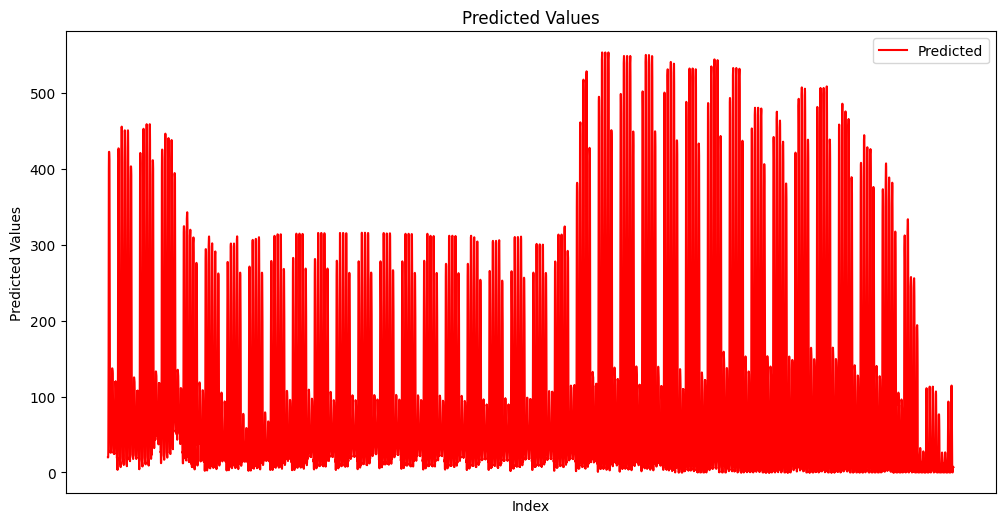

In [165]:

# Load the trained model
loaded_model = joblib.load('trained_model.joblib')

# Make predictions using the loaded model
y_pred_loaded = loaded_model.predict(X_test_df_2)
y_pred_loaded = np.maximum(y_pred_loaded, 0)

# Create a DataFrame with the predicted values
predictions_df = pd.DataFrame({'Predicted': y_pred_loaded})

# Plot the predicted values without showing the x-axis
plt.figure(figsize=(12, 6))
plt.plot(predictions_df['Predicted'], label='Predicted', color='red')
plt.xlabel('Index')
plt.ylabel('Predicted Values')
plt.title('Predicted Values')
plt.legend()

# Hide the x-axis labels
plt.xticks([])
plt.show()